# Optimización Logística en E-Commerce: Predicción de Tiempos de Entrega (Olist)

## 1. Contexto del Negocio y Definición del Problema
En el competitivo ecosistema del comercio electrónico, la eficiencia logística no es solo un costo operativo, sino un **diferenciador clave para la satisfacción del cliente**. Este proyecto, basado en mi Memoria de Título de Ingeniería Civil Industrial (UTFSM), aborda el desafío de la **"Última Milla"** en el mercado brasileño utilizando datos reales de **Olist**.

### El Desafío: La Geografía Brasileña
Brasil posee una extensión continental y una infraestructura vial compleja. Los métodos tradicionales de cálculo de tiempos estimados suelen fallar al no considerar variables críticas como la **distancia real por carretera** o la estacionalidad (festivos).

### Objetivo del Análisis
Transformar datos transaccionales crudos en un **Dataset Analítico Robusto** que permita modelar la relación entre una **Variable Dependiente ($Y$)** (Tiempo de Entrega) y múltiples **Variables Independientes ($X_i$)** (Distancia, Volumen, Festivos), con el fin de reducir la incertidumbre en la promesa de entrega.

---

## 2. Estructura de Datos y Esquema Relacional
Para comprender el flujo de una orden, analizamos el ecosistema de Olist que consta de 8 tablas interconectadas. La integridad de estas relaciones es vital para construir nuestro dataset final.

**Esquema Relacional:**
![Esquema Relacional Olist](../references/schema.png)

Procedemos a la carga de datos utilizando una arquitectura de rutas relativas para garantizar la reproducibilidad del código.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. CONFIGURACIÓN DE RUTAS RELATIVAS
# Definimos la ruta base para que el código funcione en cualquier equipo
base_path = os.path.join("..", "data", "raw")
output_path = os.path.join("..", "data", "processed")
os.makedirs(output_path, exist_ok=True)

print(f"Directorio de lectura: {os.path.abspath(base_path)}")

# 2. CARGA DE TODOS LOS DATASETS
# Usamos codificación utf-8-sig para manejar correctamente los caracteres latinos
try:
    customers = pd.read_csv(os.path.join(base_path, "olist_customers_dataset.csv"), encoding='utf-8-sig')
    geolocation = pd.read_csv(os.path.join(base_path, "olist_geolocation_dataset.csv"), encoding='utf-8-sig')
    order_items = pd.read_csv(os.path.join(base_path, "olist_order_items_dataset.csv"), encoding='utf-8-sig')
    order_payments = pd.read_csv(os.path.join(base_path, "olist_order_payments_dataset.csv"), encoding='utf-8-sig')
    order_reviews = pd.read_csv(os.path.join(base_path, "olist_order_reviews_dataset.csv"), encoding='utf-8-sig')
    orders = pd.read_csv(os.path.join(base_path, "olist_orders_dataset.csv"), encoding='utf-8-sig')
    products = pd.read_csv(os.path.join(base_path, "olist_products_dataset.csv"), encoding='utf-8-sig')
    sellers = pd.read_csv(os.path.join(base_path, "olist_sellers_dataset.csv"), encoding='utf-8-sig')
    
    print("Carga exitosa de todas las tablas.")
    
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo. Detalle: {e}")

# 3. ANÁLISIS DE TIPOS DE DATOS (DTYPES)
# Revisamos una muestra para entender qué estamos manipulando
lista_dfs = [
    ("Customers", customers),
    ("Geolocation", geolocation),
    ("Order_items", order_items),
    ("Order_payments", order_payments),
    ("Order_reviews", order_reviews),
    ("Orders", orders),
    ("Products",products),
    ("Sellers", sellers)

    
]

print("\n--- Análisis de Tipos de Datos (Muestra) ---")
for name, df in lista_dfs:
    print(f"\nTabla: {name}")
    print(df.dtypes)

Directorio de lectura: c:\Users\admin\Documents\_code\analitica-olist-datalized\data\raw
Carga exitosa de todas las tablas.

--- Análisis de Tipos de Datos (Muestra) ---

Tabla: Customers
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

Tabla: Geolocation
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

Tabla: Order_items
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

Tabla: Order_payments
order_id                 object
payment_sequential        int64
payment_type             object
payment_installments    

# 2. Auditoría de Calidad de Datos (Valores Nulos)

Una vez cargados los datos, utilizamos una estructura de listas para identificar rápidamente qué tablas contienen valores nulos y en qué magnitud. Esto nos permite focalizar los esfuerzos de limpieza solo donde es necesario.

In [2]:
# Crear una lista de DataFrames con valores nulos para iterar eficientemente
dataframes_con_nulos = [(name, df.isna().sum()) for name, df in [
    ("customers", customers),
    ("geolocation", geolocation),
    ("order_items", order_items),
    ("order_payments", order_payments),
    ("order_reviews", order_reviews),
    ("orders", orders),
    ("products", products),
    ("sellers", sellers)
] if df.isna().any().any()]

# Imprimir resumen de DataFrames con valores nulos
if dataframes_con_nulos:
    print("Resumen de DataFrames CON valores nulos:")
    for df_name, df_missing_values in dataframes_con_nulos:
        print(f"\nDataFrame '{df_name}':")
        print(f"Cantidad de valores nulos por columna:")
        print(df_missing_values[df_missing_values > 0]) # Solo mostramos las columnas afectadas

# Crear una lista de DataFrames sin valores nulos
dataframes_sin_nulos = [name for name, df in [
    ("customers", customers),
    ("geolocation", geolocation),
    ("order_items", order_items),
    ("order_payments", order_payments),
    ("order_reviews", order_reviews),
    ("orders", orders),
    ("products", products),
    ("sellers", sellers)
] if not df.isna().any().any()]

# Imprimir resumen de DataFrames sin valores nulos
if dataframes_sin_nulos:
    print("\nResumen de DataFrames SIN valores nulos (Listos para usar):")
    for df_name in dataframes_sin_nulos:
        print(f"DataFrame '{df_name}' está limpio.")

Resumen de DataFrames CON valores nulos:

DataFrame 'order_reviews':
Cantidad de valores nulos por columna:
review_comment_title      87656
review_comment_message    58247
dtype: int64

DataFrame 'orders':
Cantidad de valores nulos por columna:
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

DataFrame 'products':
Cantidad de valores nulos por columna:
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Resumen de DataFrames SIN valores nulos (Listos para usar):
DataFrame 'customers' está limpio.
DataFrame 'geolocation' está limpio.
DataFrame 'order_items' está limpio.
DataFrame 'order_payments' está limpio.
DataFrame 'sellers' está limpio.


# 3. Análisis de Valores Nulos y Estrategia de Imputación

Tras la auditoría inicial, detectamos 3 dataframes críticos con información faltante. A continuación, se detalla el análisis y la estrategia de tratamiento para cada uno, basada en el impacto que tienen sobre el modelo de negocio.

### 1. Análisis: DataFrame `order_reviews`
* **Situación:** Gran cantidad de nulos en `review_comment_title` y `review_comment_message`.
* **Observación:** La ausencia de comentario no invalida la evaluación numérica (`score`). Es posible inferir patrones incluso si el cliente no escribió texto.
* **Decisión:** No eliminar registros. Imputar los campos de texto vacíos con la etiqueta **"without comments"**.

### 2. Análisis: DataFrame `orders`
* **Situación:** Nulos en `order_approved_at`, `order_delivered_carrier_date` y `order_delivered_customer_date`.
* **Observación:** * `order_delivered_customer_date`: Es vital pues compone la variable dependiente (Target: Tiempo de Entrega). Eliminarla masivamente podría sesgar el análisis.
    * Las otras dos fechas no son críticas para la primera iteración del modelo.
* **Decisión:** * Para `order_delivered_customer_date`: Asignar la misma fecha de compra (`order_purchase_timestamp`). Esto genera un tiempo de entrega de 0, indicando que el pedido no se completó o está pendiente, permitiendo identificar estos casos mediante una variable bandera (flag) posteriormente.
    * Para las otras fechas: Se mantienen nulas por ahora.

### 3. Análisis: DataFrame `products`
* **Situación:** Nulos en Categoría y Dimensiones/Peso (pocos casos).
* **Observación:** La categoría es una variable categórica relevante (ej. electrónica vs. alimentos). Las dimensiones son críticas para el cálculo de fletes.
* **Decisión:**
    * **Categoría:** Imputar con **"without category"**.
    * **Dimensiones/Peso:** Al ser pocos registros, se asume que son productos digitales o insignificantes en tamaño. Se imputa con un valor mínimo de **0.1** para evitar errores matemáticos (división por cero) en cálculos volumétricos futuros.

In [3]:
print("--- Iniciando Tratamiento de Valores Nulos ---")

# 1. TRATAMIENTO: DataFrame 'order_reviews'
# Asignar "without comments" a los valores nulos en las columnas de texto
order_reviews['review_comment_title'].fillna('without comments', inplace=True)
order_reviews['review_comment_message'].fillna('without comments', inplace=True)
print("'order_reviews': Textos nulos imputados.")

# 2. TRATAMIENTO: DataFrame 'orders'
# Estrategia: Si no hay fecha de entrega, asumimos fecha de compra (Delta = 0)
# Esto evita eliminar la fila, permitiendo analizarla como "no entregado"
orders['order_delivered_customer_date'].fillna(orders['order_purchase_timestamp'], inplace=True)
print("'orders': Fechas de entrega nulas imputadas con fecha de compra.")

# 3. TRATAMIENTO: DataFrame 'products'
# Asignar "without category" a las columnas categóricas
cols_cat = ['product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty']
for col in cols_cat:
    products[col].fillna('without category', inplace=True)

# Asignar 0.1 a las columnas de dimensiones y peso (Valor mínimo técnico)
cols_num = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
for col in cols_num:
    products[col].fillna(0.1, inplace=True)

print("'products': Categorías y dimensiones imputadas.")

print("\n--- Mejoras implementadas correctamente ---")

--- Iniciando Tratamiento de Valores Nulos ---
'order_reviews': Textos nulos imputados.
'orders': Fechas de entrega nulas imputadas con fecha de compra.
'products': Categorías y dimensiones imputadas.

--- Mejoras implementadas correctamente ---


C:\Users\admin\AppData\Local\Temp\ipykernel_7252\1332459925.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  order_reviews['review_comment_title'].fillna('without comments', inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_7252\1332459925.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [4]:
# ---------------------------------------------------------------
# VALIDACIÓN DE LA IMPLEMENTACIÓN
# ---------------------------------------------------------------
# Se espera obtener valores nulos SOLO en 2 columnas de 'orders':
# - order_approved_at
# - order_delivered_carrier_date
# Estas dos columnas no juegan un rol en el modelo actual.

print("\n--- Auditoría de Control Post-Limpieza ---")

# 1. Lista de DataFrames que AÚN tienen nulos
dataframes_con_nulos = [(name, df.isna().sum()) for name, df in [
    ("customers", customers),
    ("geolocation", geolocation),
    ("order_items", order_items),
    ("order_payments", order_payments),
    ("order_reviews", order_reviews),
    ("orders", orders),
    ("products", products),
    ("sellers", sellers)
] if df.isna().any().any()]

if dataframes_con_nulos:
    print("Resumen de DataFrames con valores nulos (Esperado: Solo 'orders'):")
    for df_name, df_missing_values in dataframes_con_nulos:
        print(f"\nDataFrame '{df_name}':")
        # Filtramos para mostrar solo las columnas que tienen nulos > 0
        print(df_missing_values[df_missing_values > 0])

# 2. Lista de DataFrames SIN valores nulos
dataframes_sin_nulos = [name for name, df in [
    ("customers", customers),
    ("geolocation", geolocation),
    ("order_items", order_items),
    ("order_payments", order_payments),
    ("order_reviews", order_reviews),
    ("orders", orders),
    ("products", products),
    ("sellers", sellers)
] if not df.isna().any().any()]

if dataframes_sin_nulos:
    print("\nResumen de DataFrames COMPLETAMENTE LIMPIOS:")
    for df_name in dataframes_sin_nulos:
        print(f"DataFrame '{df_name}' no tiene valores nulos.")


--- Auditoría de Control Post-Limpieza ---
Resumen de DataFrames con valores nulos (Esperado: Solo 'orders'):

DataFrame 'orders':
order_approved_at                160
order_delivered_carrier_date    1783
dtype: int64

Resumen de DataFrames COMPLETAMENTE LIMPIOS:
DataFrame 'customers' no tiene valores nulos.
DataFrame 'geolocation' no tiene valores nulos.
DataFrame 'order_items' no tiene valores nulos.
DataFrame 'order_payments' no tiene valores nulos.
DataFrame 'order_reviews' no tiene valores nulos.
DataFrame 'products' no tiene valores nulos.
DataFrame 'sellers' no tiene valores nulos.


# 4. Construcción del Dataset Base: Variable Dependiente y Variables Independientes

Habiendo saneado las tablas dimensionales (`products`, `sellers`, `customers`) y la tabla de hechos (`orders`), procedemos a la **unificación de los datos** para estructurar la matriz de variables.

**Metodología:**
1.  **Selección de Variables:** Se filtran solo las columnas necesarias para construir la **Variable Dependiente** ($Y$) y las **Variables Independientes** ($X$) del modelo, optimizando el uso de memoria.
2.  **Uniones (Joins):** Se utiliza `INNER JOIN` para asegurar que cada registro posea la información completa de la transacción.
3.  **Validación de Integridad:** Se verifica la inexistencia de valores nulos para asegurar la calidad de la muestra.

In [5]:
# --- SELECCIÓN DE COLUMNAS DE INTERÉS ---
# Definimos subconjuntos específicos para el análisis de regresión
customers_sel = customers[['customer_city','customer_id', 'customer_state', 'customer_unique_id', 'customer_zip_code_prefix']]

order_items_sel = order_items[['freight_value', 'order_id', 'order_item_id', 'price', 'product_id', 
                           'seller_id', 'shipping_limit_date']]

orders_sel = orders[['customer_id', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
                  'order_estimated_delivery_date', 'order_id', 'order_purchase_timestamp', 'order_status']]

products_sel = products[['product_category_name', 'product_description_lenght', 'product_height_cm', 
                     'product_id', 'product_length_cm', 'product_photos_qty', 'product_weight_g',
                     'product_width_cm']]

sellers_sel = sellers[['seller_city', 'seller_id', 'seller_state', 'seller_zip_code_prefix']]

# --- EJECUCIÓN DE UNIONES (MERGE) ---
print("Ejecutando Joins...")

# 1) Items + Orders
merged_df = pd.merge(order_items_sel, orders_sel, on='order_id', how='inner')

# 2) + Products
merged_df = pd.merge(merged_df, products_sel, on='product_id', how='inner')

# 3) + Sellers
merged_df = pd.merge(merged_df, sellers_sel, on='seller_id', how='inner')

# 4) + Customers
merged_df = pd.merge(merged_df, customers_sel, on='customer_id', how='inner')

# --- DATASET FINAL ---
# Selección final de variables para el modelo
selected_columns = [
    'order_delivered_customer_date', 
    'order_purchase_timestamp', 
    'product_height_cm',
    'product_length_cm', 
    'product_weight_g', 
    'product_width_cm', 
    'seller_state',
    'customer_state'
]

new_df = merged_df[selected_columns].copy()

# --- VALIDACIÓN FINAL ---
print("\n######### Validación del Dataset Maestro (new_df) #######")

# Verificar nulos y tipos
nulos_por_columna = new_df.isna().sum()
tipos_por_columna = new_df.dtypes

resumen_df = pd.DataFrame({
    'Tipo de Dato': tipos_por_columna,
    'Valores Nulos': nulos_por_columna
})

print(resumen_df)

# Alerta visual de integridad
if nulos_por_columna.sum() == 0:
    print("\nÉXITO: El dataset final no contiene valores nulos.")
else:
    print("\nALERTA: Existen valores nulos en el dataset final.")

# --- GUARDADO ---
# Usamos output_path (ruta relativa definida al inicio)
file_name = "00_df_base_sin_nulos.csv"
save_path = os.path.join(output_path, file_name)

new_df.to_csv(save_path, index=False)
print(f"\nArchivo guardado exitosamente en: {save_path}")

Ejecutando Joins...

######### Validación del Dataset Maestro (new_df) #######
                              Tipo de Dato  Valores Nulos
order_delivered_customer_date       object              0
order_purchase_timestamp            object              0
product_height_cm                  float64              0
product_length_cm                  float64              0
product_weight_g                   float64              0
product_width_cm                   float64              0
seller_state                        object              0
customer_state                      object              0

ÉXITO: El dataset final no contiene valores nulos.

Archivo guardado exitosamente en: ..\data\processed\00_df_base_sin_nulos.csv


# 5. Cálculo de Variable Independiente Crítica: Distancia (`distance_km`)

Dentro de las variables independientes ($X$), la distancia física es un predictor determinante para el tiempo de entrega ($Y$). Se realiza un análisis comparativo para seleccionar la fuente de datos más representativa de la realidad logística.

### Enfoques Analizados

1.  **Distancia Haversine (Teórica):**
    * Cálculo matemático de la distancia ortodrómica (línea recta) entre las coordenadas de latitud y longitud del vendedor y el cliente.
    * *Limitación:* Ignora la topografía y el diseño de la red vial.

2.  **Distancia Vial (Base de Datos Propia):**
    * Distancia real en kilómetros considerando rutas por carretera.
    * **Metodología de Construcción:** Esta variable se obtuvo mediante una **matriz construida manualmente**, extrayendo los registros de rutas reales desde la plataforma especializada [Distância Entre as Cidades](https://www.distanciaentreascidades.com.br).
    * **Archivo Fuente:** `distancia_ciudades.xlsx`.

### Justificación de la Selección
El análisis gráfico (Scatter Plot a continuación) demuestra que la **Distancia Haversine** subestima sistemáticamente los tiempos al asumir una ruta lineal inexistente. Por consiguiente, se incorpora la **Distancia Vial** como la variable independiente definitiva ($X_{dist}$) para el modelo, ya que captura la fricción real del transporte terrestre en Brasil.

Datasets cargados para cálculo de distancia.
Calculando distancias viales (Ruta Real)...


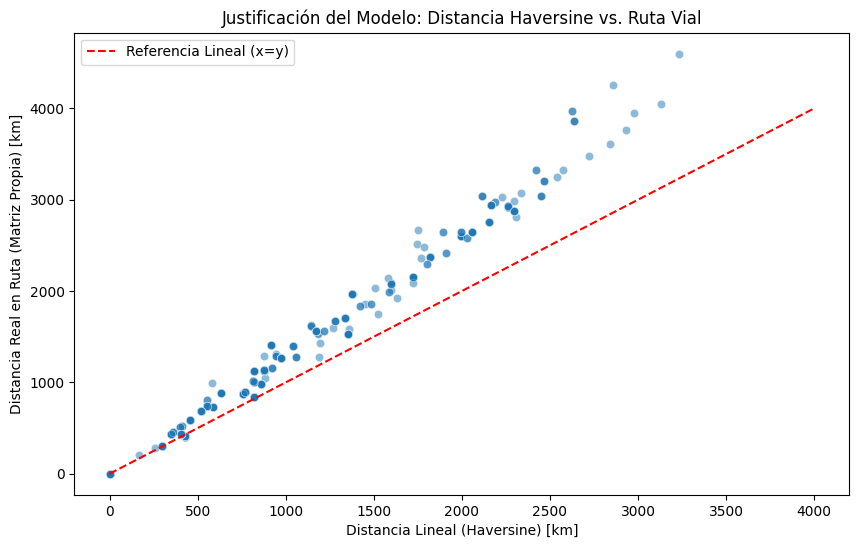

Observación: La dispersión sobre la línea roja confirma que la distancia vial es mayor, capturando la realidad logística.
Archivo intermedio guardado: 01_df_base_con_distancia.csv


In [6]:
# 1. CARGA DE DATOS PREVIOS Y AUXILIARES
# -------------------------------------------------------------------------
# Cargamos el dataset base limpio del paso anterior
try:
    path_base = os.path.join(output_path, "00_df_base_sin_nulos.csv")
    new_df = pd.read_csv(path_base)
    
    # Cargar Matriz de Distancias (Tu Excel)
    path_dist_matrix = os.path.join(base_path, "distancia_ciudades.xlsx")
    # Nota: index_col=0 asume que la primera columna son los estados de origen
    if os.path.exists(path_dist_matrix):
        distancia_estados_df = pd.read_excel(path_dist_matrix, index_col=0)
    else:
        # Fallback a CSV si se convirtió previamente
        distancia_estados_df = pd.read_csv(os.path.join(base_path, "distancia_ciudades.xlsx - Hoja1.csv"), index_col=0)

    print("Datasets cargados para cálculo de distancia.")

except FileNotFoundError as e:
    print(f"Error al cargar archivos: {e}")

# 2. CÁLCULO DISTANCIA VIAL (Lógica Propia)
# -------------------------------------------------------------------------
def calcular_distancia_vial(seller_state, customer_state):
    try:
        # Acceder a la distancia: Columna=Vendedor, Índice=Cliente (según estructura de tu Excel)
        return distancia_estados_df.loc[customer_state, seller_state]
    except KeyError:
        return np.nan # Manejo de errores si un estado no existe en la matriz

# Aplicar la función (axis=1 para ir fila por fila)
print("Calculando distancias viales (Ruta Real)...")
new_df['distance_km'] = new_df.apply(lambda row: calcular_distancia_vial(row['seller_state'], row['customer_state']), axis=1)

# 3. CÁLCULO DISTANCIA HAVERSINE (Solo para comparación)
# -------------------------------------------------------------------------
# Necesitamos coordenadas promedio de los estados para hacer el cálculo Haversine
# (Si no las tenemos en new_df, las sacamos de geolocation rapidito)
geo_temp = geolocation.groupby('geolocation_state')[['geolocation_lat', 'geolocation_lng']].mean()

# Merge temporal para tener coordenadas
df_comp = new_df.merge(geo_temp, left_on='seller_state', right_index=True)\
                .rename(columns={'geolocation_lat':'lat_s', 'geolocation_lng':'lng_s'})\
                .merge(geo_temp, left_on='customer_state', right_index=True)\
                .rename(columns={'geolocation_lat':'lat_c', 'geolocation_lng':'lng_c'})

def haversine_calc(lat1, lon1, lat2, lon2):
    R = 6371
    p = np.pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p) * np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p))/2
    return 2 * R * np.arcsin(np.sqrt(a))

df_comp['dist_haversine'] = haversine_calc(df_comp['lat_s'], df_comp['lng_s'], df_comp['lat_c'], df_comp['lng_c'])

# 4. GRÁFICO DE JUSTIFICACIÓN TÉCNICA
# -------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
# Muestra aleatoria para no saturar el gráfico
sns.scatterplot(data=df_comp.sample(2000, random_state=42), x='dist_haversine', y='distance_km', alpha=0.5)
plt.plot([0, 4000], [0, 4000], 'r--', label='Referencia Lineal (x=y)')
plt.title("Justificación del Modelo: Distancia Haversine vs. Ruta Vial")
plt.xlabel("Distancia Lineal (Haversine) [km]")
plt.ylabel("Distancia Real en Ruta (Matriz Propia) [km]")
plt.legend()
plt.show()

print("Observación: La dispersión sobre la línea roja confirma que la distancia vial es mayor, capturando la realidad logística.")

# Guardar etapa intermedia
new_df.to_csv(os.path.join(output_path, '01_df_base_con_distancia.csv'), index=False)
print("Archivo intermedio guardado: 01_df_base_con_distancia.csv")

# 6. Formalización de Variables del Modelo de Regresión

A partir del dataset enriquecido, procedemos a operacionalizar las variables para el ajuste del modelo ($Y = \beta_0 + \beta_1 X_1 + ... + \epsilon$).

### Definición de Variables

**1. Variable Dependiente ($Y$):**
* `order_delivery_time`: Tiempo real de entrega (días). Es la variable respuesta que buscamos predecir.

**2. Variables Independientes ($X_i$):**
* `distance_km`: Distancia vial (Logística).
* `product_volume_cm3`: Volumen del producto (Cubicaje).
* `product_weight_g`: Peso físico.
* `is_holiday`: Variable binaria ($1$ = Festivo, $0$ = Hábil).
* `day_purchase`, `month_purchase`, `year_purchase`: Componentes temporales (Estacionalidad).

In [ ]:
# Cargar dataset de la etapa anterior (para asegurar flujo limpio)
new_df = pd.read_csv(os.path.join(output_path, "01_df_base_con_distancia.csv"))

# Asegurar formato datetime
new_df['order_purchase_timestamp'] = pd.to_datetime(new_df['order_purchase_timestamp'])
new_df['order_delivered_customer_date'] = pd.to_datetime(new_df['order_delivered_customer_date'])

# 1. VARIABLE: Volumen del Producto (cm3)
new_df['product_volume_cm3'] = new_df['product_height_cm'] * new_df['product_length_cm'] * new_df['product_width_cm']

# 2. VARIABLE TARGET: Tiempo de Entrega (Días)
new_df['order_delivery_time'] = (new_df['order_delivered_customer_date'] - new_df['order_purchase_timestamp']).dt.days

# 3. VARIABLES TEMPORALES: Descomposición de Fecha
days_map = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
# Usamos day_name() en inglés por defecto de pandas, luego mapeamos a numérico
new_df['day_purchase'] = new_df['order_purchase_timestamp'].dt.day_name().map(days_map)
new_df['month_purchase'] = new_df['order_purchase_timestamp'].dt.month
new_df['year_purchase'] = new_df['order_purchase_timestamp'].dt.year

# 4. VARIABLE: Días Festivos (Impacto Operacional)
# Carga de archivo de feriados
try:
    path_holidays = os.path.join(base_path, "holidays.xlsx")
    if os.path.exists(path_holidays):
        holidays_df = pd.read_excel(path_holidays)
    else:
        holidays_df = pd.read_csv(os.path.join(base_path, "holidays.xlsx - Hoja1.csv"))
    
    # Conversión a datetime
    holidays_df['holiday'] = pd.to_datetime(holidays_df['holiday'])
    
    # Lógica isin(): Comparamos solo la parte fecha (.date)
    print("Cruzando fechas con calendario de festivos...")
    new_df['is_holiday'] = new_df['order_purchase_timestamp'].dt.date.isin(holidays_df['holiday'].dt.date).astype(int)
    
except Exception as e:
    print(f"⚠️ Advertencia: No se pudo calcular 'is_holiday'. Detalle: {e}")
    new_df['is_holiday'] = 0

# 5. SELECCIÓN FINAL Y EXPORTACIÓN
# Filtramos solo las columnas numéricas y targets para el modelo de regresión
cols_finales = [
    'order_delivery_time',  # Variable Dependiente (Y)
    'day_purchase', 
    'month_purchase', 
    'year_purchase', 
    'is_holiday', 
    'product_weight_g', 
    'product_volume_cm3', 
    'distance_km',          # Variable Independiente Crítica (X)
    'seller_state',         # Agregado para Dashboard Power BI
    'customer_state'        # Agregado para Dashboard Power BI
]

new_df_reduced = new_df[cols_finales].copy()

# Guardado final
path_final = os.path.join(output_path, "02_df_pre_regresion_powerbi.csv")
new_df_reduced.to_csv(path_final, index=False)

print(f"\n✅ Archivo guardado: {path_final}")
print("Este archivo '02_df_regresion.csv' está listo para ingresar al modelo de Machine Learning.")
print("\nMuestra del Dataset Final:")
print(new_df_reduced.head())

Cruzando fechas con calendario de festivos...

✅ Archivo guardado: ..\data\processed\02_df_regresion.csv
Este archivo '02_df_regresion.csv' está listo para ingresar al modelo de Machine Learning.

Muestra del Dataset Final:
   order_delivery_time  day_purchase  month_purchase  year_purchase  \
0                    7             3               9           2017   
1                   16             3               4           2017   
2                    7             7               1           2018   
3                    6             3               8           2018   
4                   25             6               2           2017   

   is_holiday  product_weight_g  product_volume_cm3  distance_km  
0           0             650.0              3528.0        430.0  
1           0           30000.0             60000.0          0.1  
2           0            3050.0             14157.0          0.1  
3           0             200.0              2400.0          0.1  
4           0 

# 7. Conclusiones y Handoff a Visualización

### Resumen del Procesamiento
Hemos transformado con éxito los datos transaccionales crudos en una matriz de datos analítica robusta, integrando lógica de negocio crítica:

1.  **Limpieza de la Variable Dependiente:** Se aseguró la integridad de la variable `order_delivery_time` imputando fechas lógicas en los registros inconsistentes.
2.  **Rigor Geográfico:** Se demostró mediante comparación gráfica que la **distancia vial** (`distance_km`) es una variable independiente superior a la distancia lineal (Haversine) para explicar la realidad logística brasileña.
3.  **Enriquecimiento de Variables Independientes:** Se incorporaron variables determinantes como la estacionalidad (`is_holiday`) y la volumetría (`product_volume_cm3`).

### Entregable Final
El archivo generado **`data/processed/02_df_regresion.csv`** contiene **112,650 registros** limpios y estructurados, listos para el modelado.

### Siguientes Pasos
Este dataset alimentará el **Panel de Control de Logística** (Power BI), donde responderemos visualmente a la pregunta de investigación:
> *"¿Qué ineficiencias logísticas (geográficas y temporales) están generando las mayores brechas entre la promesa de venta y la entrega real?"*